## Dataset Preparation
So we are about to extract features from the dataset sound using MFCC, put it in a json file,

In [1]:
#import dataset related packages

import librosa
import os
import json

SAMPLES_TO_CONSIDER = 22050*1 # sampling rate, remember nyquist theorem (default is 44100 hz so half of it?) * 1 means one second
SAMPLES_TO_CONSIDER

22050

In [2]:
def preprocess_dataset(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):

    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    }
    count=0

    # loop through all sub-dirs
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                # load audio file and slice it to ensure length consistency among different files
                signal, sample_rate = librosa.load(file_path)

                # drop audio files with less than pre-decided number of samples
                if len(signal) >= SAMPLES_TO_CONSIDER:

                    # ensure consistency of the length of the signal
                    signal = signal[:SAMPLES_TO_CONSIDER]

                    # extract MFCCs
                    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                    hop_length=hop_length)

                    # store data for analysed track
                    count=count+1
                    data["MFCCs"].append(MFCCs.T.tolist())
                    data["labels"].append(i-1)
                    data["files"].append(file_path)
                    print(str(count)+" {}: {}".format(file_path, i-1))

    # save data in json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


In [3]:
preprocess_dataset('dataset/mixed/', 'mixedformat.json')


Processing: 'domestic'
1 dataset/mixed/domestic\00 - Dataset - Amanda2.wav: 0
2 dataset/mixed/domestic\00 - Dataset - WhatsApp Audio 2021-05-23 at 07.43.49 (1).wav: 0
3 dataset/mixed/domestic\00 - domestic - audio 101.wav: 0
4 dataset/mixed/domestic\00 - domestic - audio 103.wav: 0
5 dataset/mixed/domestic\00 - domestic - audio 104.wav: 0
6 dataset/mixed/domestic\00 - domestic - audio 105.wav: 0
7 dataset/mixed/domestic\00 - domestic - audio 106.wav: 0
8 dataset/mixed/domestic\00 - domestic - audio 107.wav: 0
9 dataset/mixed/domestic\00 - domestic - audio 109.wav: 0
10 dataset/mixed/domestic\00 - domestic - audio 110.wav: 0
11 dataset/mixed/domestic\00 - domestic - audio 111.wav: 0
12 dataset/mixed/domestic\00 - domestic - audio 112.wav: 0
13 dataset/mixed/domestic\00 - domestic - audio 118.wav: 0
14 dataset/mixed/domestic\00 - domestic - audio 120.wav: 0
15 dataset/mixed/domestic\00 - domestic - audio 19.wav: 0
16 dataset/mixed/domestic\00 - domestic - audio 21.wav: 0
17 dataset/mixe

## Call json and train the model
call the json, put the features into the neural model, fine tune, (we were super overfitted)

In [4]:
#import training related packages

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

DATA_PATH = "mixedformat.json"
SAVED_MODEL_PATH = "training_mix_nowseesthevalid.h5"
EPOCHS = 100
BATCH_SIZE = 8
PATIENCE = 10
LEARNING_RATE = 0.0001

In [5]:
def prepare_dataset(data_path, test_size=0.1, validation_size=0.1):
    # load dataset
    X, y = load_data(data_path)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [6]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y

In [7]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.00001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    tf.keras.layers.Dropout(0.5)

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.00001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    tf.keras.layers.Dropout(0.2)

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.00001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    tf.keras.layers.Dropout(0.2)

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

In [8]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

In [9]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    plt.figure(figsize=(5,10))

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    

    plt.show()

In [10]:
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

Training sets loaded!


In [11]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 4, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 4, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 1, 32)          4

In [12]:
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

Epoch 1/100


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-8-d85deda8a139>:6) ]] [Op:__inference_train_function_1366]

Function call stack:
train_function


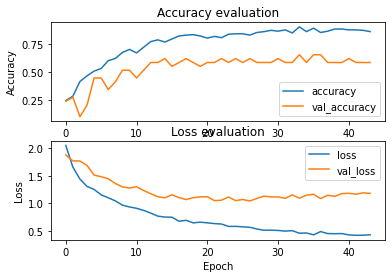

<Figure size 360x720 with 0 Axes>

In [51]:
plot_history(history)

In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 257ms/step - loss: 1.2572 - accuracy: 0.5625


In [53]:
test_loss

1.2572075128555298

In [54]:
test_acc

0.5625

In [55]:
model.save(SAVED_MODEL_PATH)

## Prediction 
Let's try this guy out

In [56]:
#preprocess the input sample function
def preprocess(file_path, num_mfcc=13, n_fft=2048, hop_length=512):
        """Extract MFCCs from audio file.
        :param file_path (str): Path of audio file
        :param num_mfcc (int): # of coefficients to extract
        :param n_fft (int): Interval we consider to apply STFT. Measured in # of samples
        :param hop_length (int): Sliding window for STFT. Measured in # of samples
        :return MFCCs (ndarray): 2-dim array with MFCC data of shape (# time steps, # coefficients)
        """

        # load audio file
        signal, sample_rate = librosa.load(file_path)

        if len(signal) >= SAMPLES_TO_CONSIDER:
            # ensure consistency of the length of the signal
            signal = signal[:SAMPLES_TO_CONSIDER]

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                         hop_length=hop_length)
        return MFCCs.T


In [57]:
loaded=tf.keras.models.load_model(SAVED_MODEL_PATH)

In [58]:
def predict(file_path):
       
        # extract MFCC
        MFCCs = preprocess(file_path)

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = loaded.predict(MFCCs)

        return predictions

In [59]:
res=predict("./dataset/testing.wav")
res

array([[0.01721677, 0.00668236, 0.94594884, 0.03015202]], dtype=float32)

In [60]:
print("Prediksi Kekerasan: \n")
print("Domestik: "+str(res[0,0]*100)+"%")
print("Fisik: "+str(res[0,1]*100)+"%")
print("Seksual: "+str(res[0,2]*100)+"%")
print("Penguntitan: "+str(res[0,3]*100)+"%")

Prediksi Kekerasan: 

Domestik: 1.7216768115758896%
Fisik: 0.6682362407445908%
Seksual: 94.5948839187622%
Penguntitan: 3.0152015388011932%
